# Procrustes Transformation to obtain consensus subject-specific structural connectomes

***Yasser Aleman, modified from Anjali Tarun, April 15 2021***

**Goal**: Extract subject-specific connectomes, compute the graph Laplacian and decompose it to obtain corresponding eigenvectors and eigenvalues. Develop a method to match the order and signs of these eigenmodes across group.

**Approach**: Use Procrustes transformation, to find the optimal rotation, in order to match these eigenvectors.

Using Orthogonal Procrustes Transform, we obtain a rotation matrix $R$ that minimizes the difference between two matrices $A$ and $B$:

This is computed by minimizing the following cost function:

$$
\begin{equation}
R = \underset{\Omega}\arg\min||\Omega A - B||_F 
\end{equation}
$$

The solution is equivalent to finding the nearest orthogonal matrix to a given matrix :

$$
\begin{equation}
M = BA^{\top}
\end{equation}
$$

This orthogonal matrix $R$ is computed by using singular value decomposition (SVD) as follows:

$$
\begin{equation}
M = U\Lambda V^{\top}
\end{equation}
$$

The rotation matrix can then be derived using:

$$
\begin{equation}
R = UV^{\top}
\end{equation}
$$

Finally, we rotate the eigenfunctions $A$ and its corresponding eigenvalues $\lambda_A$ as:

$$
\begin{equation}
A' = RA \\
\lambda_A' = U\lambda_A R 
\end{equation}
$$

In the following, we apply this technique in a set of 10 subjects using the Lausanne scale 3 parcellation.

In [ ]:
import numpy as np
import networkx as nx
from os import path as op
from scipy import linalg, dot
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.spatial.distance as sis
from scipy import stats
import h5py
import pandas as pd
import os
from shutil import copyfile
from scipy.io import savemat


In [5]:
def readFile(filepath, weight):
    ''' Reads the file found in filepath.
        Returns the output in adjacency format A with weight definitions given by weight (e.g., fiber density)
    '''
    
    if filepath[-4:] == '.mat':
        f = sio.loadmat(mainpath + fileD)
        A = f['sc'][weight]
        A = A[0,0]
    else:
        G = nx.read_gpickle(mainpath+ fileD)

        for u,v,d in G.edges(data=True):
            weight_val = d[weight]
            G.remove_edge(u,v)
            G.add_edge(u,v)
            G[u][v][weight] = weight_val

        A = nx.adjacency_matrix(G).todense()
    return A

In [7]:
# Search the value inside a vector
def search(values, searchFor):
    ret = []
    for k, v in values.items():
        if searchFor in v:
            ret.append(k)
    return ret

In [8]:
# Creating the ismember function for python
def mypy_ismember(a_vec, b_vec):
    bool_ind = np.in1d(a_vec, b_vec)
    bool_ind = np.reshape(bool_ind,np.shape(a_vec))
    return bool_ind

In [9]:
# Creating the function to read the colorlut
def read_fscolorlut(lutFile):
    fid = open(lutFile)
    LUT = fid.readlines()
    fid.close()

    # Make dictionary of labels
    LUT = [row.split() for row in LUT]
    lab = {}
    lnames = []
    for row in LUT:
        if len(row)>1 and row[0][0] is not '#' and row[0][0] is not '\\': # Get rid of the comments
            lname = row[1]
            lab[np.int(row[0])] = lname
            lnames.append(lname)
    return lnames, lab

In [12]:
# Creating the function to read the colorlut
def read_fscolorlut(lutFile):
    fid = open(lutFile)
    LUT = fid.readlines()
    fid.close()

    # Make dictionary of labels
    LUT = [row.split() for row in LUT]
    lab = {}
    lnames = []
    for row in LUT:
        if len(row)>1 and row[0][0] is not '#' and row[0][0] is not '\\': # Get rid of the comments
            lname = row[1]
            lab[int(row[0])] = lname
            lnames.append(lname)
    return lnames, lab

In [13]:
# Reading the colorlut and detecting the ROIs
lutFile = '/media/yaleman/Database/PROCESSING_RESULTS/5-freesurfer_processing/sub-A001_ses-20150715154733/mri/lausanne2018.scale4.sym.corrected_FreeSurferColorLUT.txt'
lname, lab = read_fscolorlut(lutFile)
ctxCodes = search(lab, 'ctx-')

# Detecting the gray matter structures in the colorlut
key = list(lab.keys())
boolCTX = mypy_ismember(key , ctxCodes)
ctxCodes = np.where(boolCTX == True)
ctxIndex = ctxCodes[0]# # Number of cortical structures

We use the fiber density as the weight definition, which is an output from the connectome mapper

In [31]:
# Load subject list
outputDir = '/media/yaleman/Database/PROCESSING_RESULTS';
prsFile = '/media/COSAS/Yasser/Work2Do/PatricSNFs/PRSscores/PRS_r0.1.txt'
data = pd.read_csv(prsFile)
print(np.shape(data)[0])
subjIds = data.values[:,0]
n_subj = len(subjIds)
A_all = np.zeros([int(np.shape(data)[0]), 3])
Nsubj = 0;

# Detecting number of subjects with connectivity matrices

for i in range(n_subj):
    subjDir = outputDir + '/' + '7-connectome' + '/' +'sub-' + subjIds[i];
    files = glob(subjDir + '*')
    if files:
        Nsubj = Nsubj + 1
        if Nsubj==1:
            Id = os.path.basename(files[0])
            connMatFile = outputDir + '/' + '7-connectome' + '/' + Id + '/' + 'connectmat' + '/' + 'lengthmat_lausanne2018.scale4.sym.corrected+aseg+2mm.mat'
            f = sio.loadmat(connMatFile)
            A = f['newConnMat'][0][0][2]
            A[np.isnan(A)] = 0

# Removing the connections between the right subfields 
xv, yv = np.meshgrid(ctxIndex,ctxIndex)
xv = np.matrix.flatten(xv)
yv = np.matrix.flatten(yv)

# Creating the empty variable
Nstruct =len(ctxIndex)
A_all = np.zeros((Nstruct,Nstruct,Nsubj))
print(np.shape(A_all))
cont = -1
for i in range(n_subj):
    print('> Process subject {}'.format(subjIds[i]))
    subjDir = outputDir + '/' + '7-connectome' + '/' +'sub-' + subjIds[i];
    files = glob(subjDir + '*')
    if files:
        cont = cont + 1 
        Id = os.path.basename(files[0])
        connMatFile = outputDir + '/' + '7-connectome' + '/' + Id + '/' + 'connectmat' + '/' + 'lengthmat_lausanne2018.scale4.sym.corrected+aseg+2mm.mat'
        destconnMatFile = '/media/COSAS/Yasser/Work2Do/PatricSNFs/Files2copy/' + Id + '_' + 'lengthmat_lausanne2018.scale4.sym.corrected+aseg+2mm.mat'
        copyfile(connMatFile,destconnMatFile)
        f = sio.loadmat(connMatFile)
        A = f['newConnMat'][0][0][2]
        A[np.isnan(A)] = 0
        T = A[np.ix_(ctxIndex,ctxIndex)]
        print(np.shape(T))
        A_all[:,:,cont] = T
#         A_all[:,:,cont] = A
       


48
(446, 446, 46)
> Process subject F001
(446, 446)
> Process subject F106
(446, 446)
> Process subject LNAC02
(446, 446)
> Process subject F098
(446, 446)
> Process subject LNAC17
(446, 446)
> Process subject L477
(446, 446)
> Process subject LNAC20
(446, 446)
> Process subject LNAC05
(446, 446)
> Process subject F109
(446, 446)
> Process subject LNAC14
(446, 446)
> Process subject LNAC09
> Process subject LNAC15
(446, 446)
> Process subject LNAC12
(446, 446)
> Process subject LNAC24
(446, 446)
> Process subject F107
(446, 446)
> Process subject LNAC18
(446, 446)
> Process subject F118
(446, 446)
> Process subject F110
(446, 446)
> Process subject LNAC29
(446, 446)
> Process subject LNAC32
(446, 446)
> Process subject F148
(446, 446)
> Process subject F126
(446, 446)
> Process subject F112
(446, 446)
> Process subject F117
> Process subject LNAC33
(446, 446)
> Process subject LNAC52
(446, 446)
> Process subject F120
(446, 446)
> Process subject LNAC41
(446, 446)
> Process subject LNAC

In [23]:
print(np.shape(A_all))

(48, 3)


In [21]:
outputDir = '/media/yaleman/Database/PROCESSING_RESULTS';
prsFile = '/media/COSAS/Yasser/Work2Do/PatricSNFs/PRSscores/PRS_r0.1.txt'
data = pd.read_csv(prsFile)
print(np.shape(data)[0])
subjIds = data.values[:,0]
n_subj = len(subjIds)
A_all = np.zeros([int(np.shape(data)[0]), 3])
Nsubj = 0;

# Detecting number of subjects with connectivity matrices

for i in range(n_subj):
    subjDir = outputDir + '/' + '7-connectome' + '/' +'sub-' + subjIds[i];
    files = glob(subjDir + '*')
    if files:
        Nsubj = Nsubj + 1
        if Nsubj==1:
            Id = os.path.basename(files[0])
            connMatFile = outputDir + '/' + '7-connectome' + '/' + Id + '/' + 'connectmat' + '/' + 'lengthmat_lausanne2018.scale4.sym.corrected+aseg+2mm.mat'
            f = sio.loadmat(connMatFile)
            print(f['newConnMat'][0][0][2])

48
[[0.         0.00422407 0.00375527 ... 0.         0.         0.        ]
 [0.00422407 0.         0.04571179 ... 0.         0.         0.        ]
 [0.00375527 0.04571179 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


We first take the average of the connectomes across the subjects considered. Next, we compute the Laplacian and decompose it to obtain its corresponding eigenvectors and eigenvalues. 

We first make sure that we normalize the Laplacian using symmetric normalization.

In [34]:
def normalize_Lap(A):
    ''' Takes the adjacency matrix as input and returns the corresponding symmetric normalized Laplacian matrix
        
    '''
    indices_diag = np.diag_indices(446)
    A[indices_diag] = 0
    D = np.sum(A,axis=1)
    D = np.diag(D)
    Dn = np.power(D, -0.5)
    Dn = np.diag(np.diag(Dn))

    # symmetric normalize Adjacency
    An = Dn@A@Dn
    Ln = np.diag(np.full(len(An),1)) - An
    # Ln = np.diag(np.sum(An,axis=1)) - An
    return Ln, An

In [35]:
# Decompose the Laplacian and plot the eigenvalues
A_group = np.mean(A_all, axis=2)
Ln_group, An_group = normalize_Lap(A_group)
P,Q = np.linalg.eigh(Ln_group)

# sort eigenvalues
order = np.argsort(P)
P = P[order]
Q = Q[:,order]


fig, axs = plt.subplots(1, 2, figsize=(10, 3))
im1 = axs[0].plot(P)
im1 = axs[0].set_title('Eigenvalues')
im2 = axs[1].imshow(Q, extent = [0,446,0,446], aspect='auto', cmap='jet', vmin = -0.1,vmax=0.1)
im2 = axs[1].set_title('Eigenvectors')
im2 = axs[1].set_xlabel('eigenvalue index')
plt.show()

np.seterr(divide = 'ignore') 


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

The eigenspectrum shows a healthy curve going from $\lambda = [0,1.6)$, as expected for symmetrically normalized graph Laplacians. Meanwhile, the eigenmodes do not reveal so much information with this plotting. Ideally, it would be great if we can project it to a cortical surface.

Next, we want to obtain the Laplacian for each adjacency matrix per subject, and perform the eigendecomposition.

In [36]:
# iterate over all subjects

P_all = np.zeros((Nstruct,Nsubj))
Q_all = np.zeros((Nstruct,Nstruct, Nsubj))
for i in range(Nsubj):
    Ln, An = normalize_Lap(A_all[:,:,i])
    P1,Q1 = np.linalg.eigh(Ln)
    # sort eigenvalues
    order = np.argsort(P1)
    P_all[:,i] = P1[order]
    Q_all[:,:,i] = Q1[:,order]
    #plt.imshow(Q1,  extent = [0,274,0,274], aspect='auto', cmap='jet', vmin = -0.1,vmax=0.1)
    #plt.show()
#     plt.plot(P1[order])

np.seterr(divide = 'ignore')     

/opt/anaconda3/envs/python37env/bin/xpython:13: RuntimeWarning: invalid value encountered in matmul


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

After aggregating the subject-specific eigenvectors, we can now compute for the rotation matrix via Procrustes transform. To do this, we use the first subject as a reference image, and then we do another step of Procrustes transformation, but in the second time, we use the mean of all transformed/rotated eigenvectors.

In [37]:
def computeRotation(A,B):
    A[np.isnan(A)] = 0
    B[np.isnan(B)] = 0
    ''' Returns the rotation matrix that solves the orthogonal Procrustes transform problem'''
    M = A*np.transpose(B)
    U, V, N = np.linalg.svd(M)
    R = U@N
    return R
    

In [38]:
# First round of rotation
Q_all_rotated = np.zeros((Nstruct,Nstruct, Nsubj))
Q_all_rotated[:,:,0] = Q_all[:,:,0]

for i in range(1, Nsubj):
    print(i)
    R = computeRotation(Q_all[:,:,0], Q_all[:,:,i])
    Q_all_rotated[:,:,i] = R@Q_all[:,:,i]
    print(np.nonzero(Q_all[:,:,i]))
    
# take the average of the rotated eigenvectors
Q_mean_rotated = np.mean(Q_all_rotated,axis=2)


#second round of Procrustes transformation
P_all_rotated = np.zeros((Nstruct,Nsubj))
for i in range(1, Nsubj):
    print(i)
    R = computeRotation(Q_mean_rotated, Q_all[:,:,i])
    Q_all_rotated[:,:,i] = R@Q_all[:,:,i]
    eig_rotated = R@Q_all[:,:,i]@np.diag(P_all[:,i])
    P_all_rotated[:,i] = np.sqrt(np.sum(np.multiply(eig_rotated,eig_rotated),axis=0))
Q_mean_rotated = np.mean(Q_all_rotated,axis=2)
plt.imshow(Q_mean_rotated,  extent = [0,446,0,446], aspect='auto', cmap='jet', vmin = -0.1,vmax=0.1)
plt.colorbar()

mdic = {"ind_eigFun": Q_all_rotated,"ind_eigVals": eig_rotated, "label": "spectDecomp"}
savemat("/home/yaleman/matlab_matrix.mat", mdic)

1
0.9493712395778947
(array([  0,   0,   0, ..., 445, 445, 445]), array([  0,   1,   2, ..., 443, 444, 445]))
2
0.9598681219144194
(array([  0,   0,   0, ..., 445, 445, 445]), array([  0,   1,   2, ..., 443, 444, 445]))
3
0.9274125710171296
(array([  0,   0,   0, ..., 445, 445, 445]), array([  0,   1,   2, ..., 443, 444, 445]))
4
0.8428731906712968
(array([  0,   0,   0, ..., 445, 445, 445]), array([  0,   1,   2, ..., 443, 444, 445]))
5
0.8950365144461615
(array([  0,   0,   0, ..., 445, 445, 445]), array([  0,   1,   2, ..., 443, 444, 445]))
6
1.0
(array([0]), array([0]))
7
0.9579047137107255
(array([  0,   0,   0, ..., 445, 445, 445]), array([  0,   1,   2, ..., 443, 444, 445]))
8
0.9704282851904505
(array([  0,   0,   0, ..., 445, 445, 445]), array([  0,   1,   2, ..., 443, 444, 445]))
9
0.9527155763690032
(array([  0,   0,   0, ..., 445, 445, 445]), array([  0,   1,   2, ..., 443, 444, 445]))
10
1.0
(array([0]), array([0]))
11
1.0
(array([0]), array([0]))
12
0.9715103720872817
(ar

In [44]:
mdic = {"ind_eigFun": Q_all_rotated,"ind_eigVals": eig_rotated, "label": "spectDecomp"}
savemat("/home/yaleman/matlab_matrix.mat", mdic)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


10.380777075082664
Maximum Value for the Fiber Length 200.46400829897811
Maximum Value for Scalarmap 0.6965566817855048


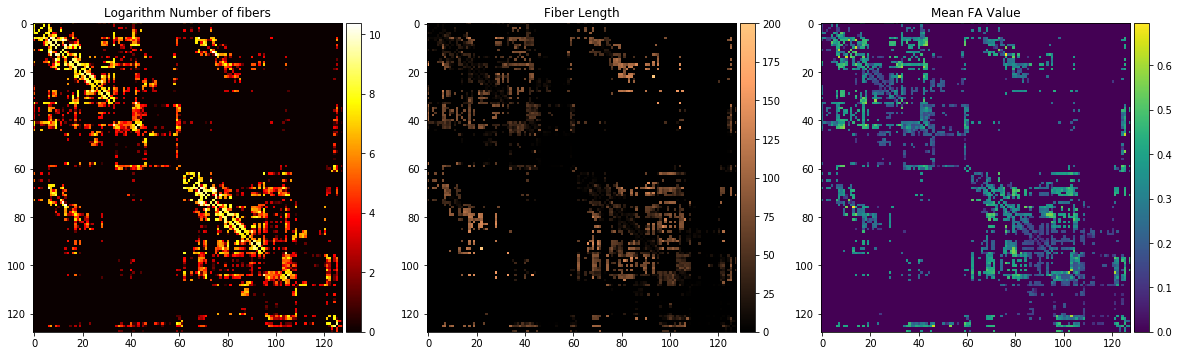

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize = (20, 20))

# Plotting the number of fibers
T = np.log(nfibMat)
T[np.isinf(T)] = 0

print(np.max(T))
pos1 = axs[0].imshow(T, cmap='hot') 
axs[0].set_title('Logarithm Number of fibers')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(pos1, cax=cax)


# Plotting the length of the fibers
pos2 = axs[1].imshow(fLengthMat,cmap='copper')
axs[1].set_title('Mean Fiber length')
axs[1].set_title('Fiber Length')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(pos2, cax=cax)
print("Maximum Value for the Fiber Length", np.max(fLengthMat))

# Plotting the mean value along the fibers
T = scalmapMat
pos3 = axs[2].imshow(T)
axs[2].set_title('Mean FA Value')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(pos3, cax=cax)
print("Maximum Value for Scalarmap", np.max(T))




In [47]:
R = computeRotation(Q_all[:,:,0], Q_all[:,:,1])

nan


ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 2, figsize = (20, 20))

pos1 = axs[0].imshow(Q_all[:,:,0], cmap='hot') 
axs[0].set_title('Logarithm Number of fibers')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(pos1, cax=cax)


# Plotting the length of the fibers
pos2 = axs[1].imshow(Q_all[:,:,1],cmap='copper')
axs[1].set_title('Mean Fiber length')
axs[1].set_title('Fiber Length')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(pos2, cax=cax)


In [41]:
np.shape(Q_mean_rotated)

(446, 446)

The matrices **Q_mean_rotated** and **P_all_rotated** contains the rotated eigenvectors and eigenvalues respectively

Let's assess the output of the transformation by evaluating the cosine similarity of the eigenmodes of two example subjects.

In [12]:
A = Q_all[:,:,0].T
B = Q_all[:,:,1].T
A_cos = dot(A,B.T)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im1 = axs[0].imshow(A_cos,cmap = 'seismic',vmin = -1,vmax=1)
im1 = axs[0].set_title('Cosine Similarity Before Rotation')
im1 = axs[0].set_xlabel('Subject 1 eigenvectors')
im1 = axs[0].set_ylabel('Subject 2 eigenvectors')


A = Q_all_rotated[:,:,0].T
B = Q_all_rotated[:,:,1].T
A_cos = dot(A,B.T)

im2 = axs[1].imshow(A_cos,cmap = 'seismic', vmin = -1,vmax=1)
im2 = axs[1].set_title('Cosine Similarity After Rotation')
im2 = axs[1].set_xlabel('Subject 1 eigenvectors')
im2 = axs[1].set_ylabel('Subject 2 eigenvectors')
#fig.colorbar(im2, ax=axs[1])

plt.show()

/opt/anaconda3/envs/python37env/bin/xpython:3: DeprecationWarning: scipy.dot is deprecated and will be removed in SciPy 2.0.0, use numpy.dot instead
/opt/anaconda3/envs/python37env/bin/xpython:14: DeprecationWarning: scipy.dot is deprecated and will be removed in SciPy 2.0.0, use numpy.dot instead


As we can see, we observe traces of flip signs and unordered eigenmodes, which is inherent when we do the eigendecomposition of individual Laplacian matrices. Now let's observe when we take the cosine similarity of the eigenmodes after rotation.

As expected, we successfully transformed the ordering of the eigenvectors of the Laplacian, hence a nice diagonal cosine similarity outcome as shown above. 

We can also then compare the average across subjects between the rotated and original eigenspectrum.

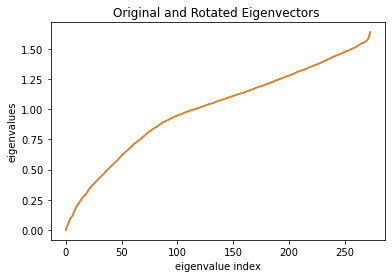

In [68]:
P_mean = np.mean(P_all,axis=1)
P_mean_rotated = np.mean(P_all_rotated, axis=1)
plt.plot(range(274),P_mean, range(274),P_mean_rotated)
plt.title('Original and Rotated Eigenvectors ')
plt.xlabel('eigenvalue index')
plt.ylabel('eigenvalues')
plt.show()

As it seems from the eigenspectrum above, there's nothing much that changed in the rotated eigenvalues. Let's compute back the Laplacian and from here back-compute the rotated SC.

## Check how does the original SC look like and compare it to rotated SC

To give an equal assessment, let's see if we can reconstruct the original raw SC using the values from the decomposed Laplacian eigenspectrum


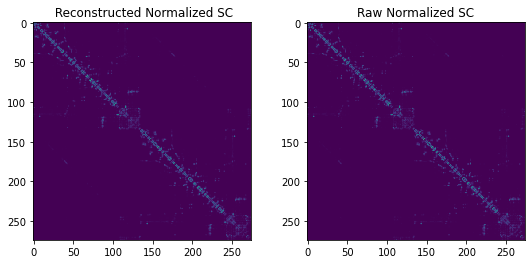

In [69]:
# reconstruct from the decomposed original Laplacian
Ln_group_recon = Q@np.diag(P)@np.linalg.inv(Q)
An_group_recon = np.diag(np.full(len(An),1)) - Ln_group_recon
An_group_recon = np.diag(np.diag(Ln_group_recon)) - Ln_group_recon


fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im1 = axs[0].imshow(An_group_recon,vmin = 0,vmax=0.5)
im1 = axs[0].set_title(' Reconstructed Normalized SC')
im2 = axs[1].imshow(An,vmin = 0,vmax=0.5)
im2 = axs[1].set_title('Raw Normalized SC')
plt.show()



Now that all looks good, it seems we can reconstruct the SC back quite well.. Let's do the same with the rotated eigenvectors and eigenvalues. 

**Question:** How does it look in logarithmic plot?

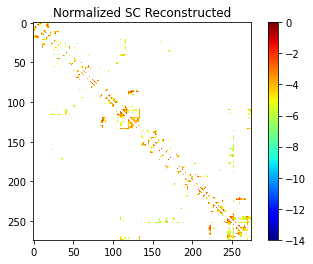

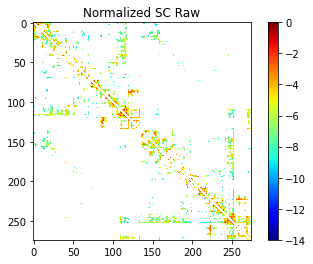

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [70]:
# reconstruct from the decomposed rotated eigenvectors and eigenvalues of the Laplacian
An_copy = np.copy(An_group_recon)
indices = An_copy<1e-3
An_copy[indices] = float('inf')
plt.imshow(np.log(An_copy),cmap = 'jet',vmin = 0,vmax=-14)
plt.title('Normalized SC Reconstructed')
plt.colorbar()
plt.show()


plt.imshow(np.log(An),cmap = 'jet',vmin = 0,vmax=-14)
plt.title('Normalized SC Raw')
plt.colorbar()
plt.show()

np.seterr(divide = 'ignore') 


**Observation** : It doesn't look so good for smaller values, but I think that's OK as this is already related to precision issues..

Now let's dive in to check how the rotated SC looks like..

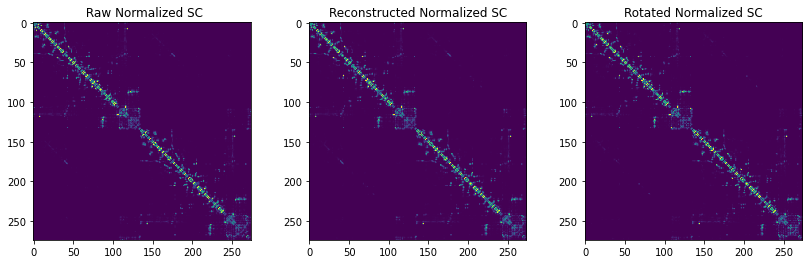

In [71]:
Ln_rotated = np.zeros((274,274, n_subj))
An_rotated = np.zeros((274,274, n_subj))
for iS in range(n_subj):
    Ln_rotated[:,:,iS] = Q_all_rotated[:,:,iS]@np.diag(P_all_rotated[:,iS])@np.linalg.inv(Q_all_rotated[:,:,iS])
    An_rotated[:,:,iS] = np.diag(np.diag(Ln_rotated[:,:,iS])) - Ln_rotated[:,:,iS]
    #plt.imshow(Ln_rotated[:,:,iS])
    
An_mean_rotated = np.mean(An_rotated,axis=2)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
im2 = axs[1].imshow(An_group_recon,vmin = 0,vmax=0.2)
im2 = axs[1].set_title('Reconstructed Normalized SC')
im1 = axs[0].imshow(An,vmin = 0,vmax=0.2)
im1 = axs[0].set_title(' Raw Normalized SC')
im3 = axs[2].imshow(An_mean_rotated,vmin = 0,vmax=0.2)
im3 = axs[2].set_title('Rotated Normalized SC')
plt.show()

**Observation:** This looks great! It seems to be capturing the same trend... maybe at least for high values of SC. Nevertheless, I think it is important to look at the logarithm scale.

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

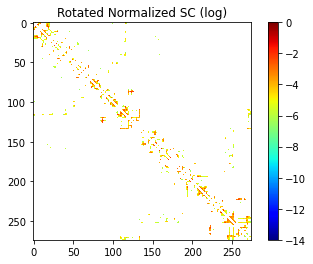

In [72]:
An_copy = np.copy(An_rotated[:,:,iS])
indices = An_copy<1e-3
An_copy[indices] = float('inf')
plt.imshow(np.log(An_copy), cmap = 'jet',vmin = 0,vmax=-14)
plt.colorbar()
plt.title('Rotated Normalized SC (log)')

np.seterr(divide = 'ignore') 

This looks a bit different from what we expect.. Although the overall pattern is still there..

## Let's assess how the results change if we binarize the SC by thresholding it to the median


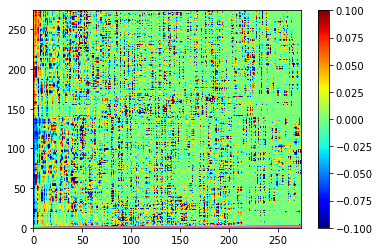

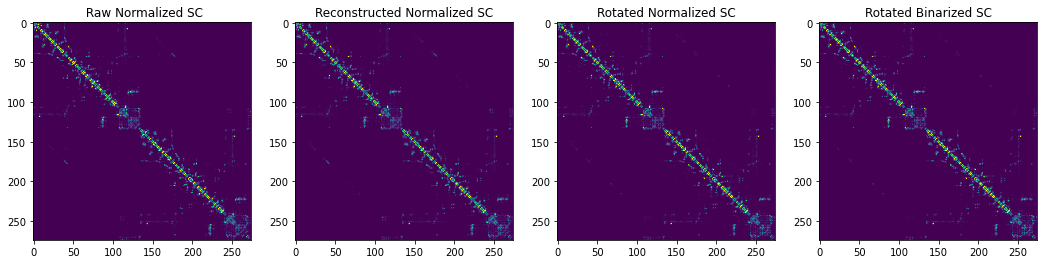

<ipython-input-73-1256c903437d>:65: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(An_rotated_thresh[:,:,iS]),cmap='jet',vmin = -2,vmax=-10)


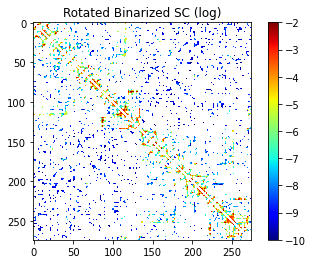

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [73]:
thresh = 1e-4
A_all_thresh = np.copy(A_all)
indices = A_all_thresh < thresh
A_all_thresh[indices] = 0
P_all_thresh = np.zeros((274,len(subject_list)))
Q_all_thresh = np.zeros((274,274, len(subject_list)))
for i in range(len(subject_list)):
    Ln, An = normalize_Lap(A_all_thresh[:,:,i])
    P1,Q1 = np.linalg.eigh(Ln)
    # sort eigenvalues
    order = np.argsort(P1)
    P_all_thresh[:,i] = P1[order]
    Q_all_thresh[:,:,i] = Q1[order,:]
    #plt.imshow(Q1,  extent = [0,274,0,274], aspect='auto', cmap='jet', vmin = -0.1,vmax=0.1)
    #plt.show()
    plt.plot(P1[order])

np.seterr(divide = 'ignore') 


Q_all_rotated_thresh = np.zeros((274,274, len(subject_list)))
Q_all_rotated_thresh[:,:,0] = Q_all_thresh[:,:,0]

for i in range(1, len(subject_list)):
    R = computeRotation(Q_all_thresh[:,:,0], Q_all_thresh[:,:,i])
    Q_all_rotated_thresh[:,:,i] = R@Q_all_thresh[:,:,i]
    
    
# take the average of the rotated eigenvectors
Q_mean_rotated_thresh = np.mean(Q_all_rotated_thresh,axis=2)


#second round of Procrustes transformation
P_all_rotated_thresh = np.zeros((274,len(subject_list)))
for i in range(len(subject_list)):
    R = computeRotation(Q_mean_rotated_thresh, Q_all_thresh[:,:,i])
    Q_all_rotated_thresh[:,:,i] = R@Q_all_thresh[:,:,i]
    eig_rotated = R@Q_all_thresh[:,:,i]@np.diag(P_all_thresh[:,i])
    P_all_rotated_thresh[:,i] = np.sqrt(np.sum(np.multiply(eig_rotated,eig_rotated),axis=0))
Q_mean_rotated_thresh = np.mean(Q_all_rotated_thresh,axis=2)
plt.imshow(Q_mean_rotated_thresh,  extent = [0,274,0,274], aspect='auto', cmap='jet', vmin = -0.1,vmax=0.1)
plt.colorbar()
plt.show()
# Reconstruct SC
Ln_rotated_thresh = np.zeros((274,274, n_subj))
An_rotated_thresh = np.zeros((274,274, n_subj))
for iS in range(n_subj):
    Ln_rotated_thresh[:,:,iS] = Q_all_rotated_thresh[:,:,iS]@np.diag(P_all_rotated_thresh[:,iS])@np.linalg.inv(Q_all_rotated_thresh[:,:,iS])
    An_rotated_thresh[:,:,iS] = np.diag(np.diag(Ln_rotated_thresh[:,:,iS])) - Ln_rotated_thresh[:,:,iS]

    
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
im2 = axs[1].imshow(An_group_recon,vmin = 0,vmax=0.2)
im2 = axs[1].set_title('Reconstructed Normalized SC')
im1 = axs[0].imshow(An,vmin = 0,vmax=0.2)
im1 = axs[0].set_title(' Raw Normalized SC')
im3 = axs[2].imshow(An_mean_rotated,vmin = 0,vmax=0.2)
im3 = axs[2].set_title('Rotated Normalized SC')
im4 = axs[3].imshow(An_rotated_thresh[:,:,iS],vmin = 0,vmax=0.2)
im4 = axs[3].set_title('Rotated Binarized SC')
plt.show()

An_copy = np.copy(An_rotated_thresh[:,:,iS])
indices = An_copy<1e-3
plt.imshow(np.log(An_rotated_thresh[:,:,iS]),cmap='jet',vmin = -2,vmax=-10)
plt.colorbar()
plt.title('Rotated Binarized SC (log)')
plt.show()
np.seterr(divide = 'ignore') 

It seems that binarized SC actually do look worse... not a good idea. :)

**Question:** Is it worth it to compare the two SC and assess the efficiency of rotated SC to retain subject-specific information?

## Apply simplicial complex analysis to average SC matrices and subject-level SC


In [74]:
# Install necessary libraries
!pip3 install gudhi
import gudhi as gd
import os
import numpy as np
from IPython.display import Image


     |████████████████████████████████| 2.4 MB 165 kB/s eta 0:00:01


First, we define what is a simplicial complex? What is a simplex?

In mathematics, a **simplicial complex** is a set composed of points, line segments, triangles, and their n-dimensional counterparts (see illustration) [Wiki]

<div>
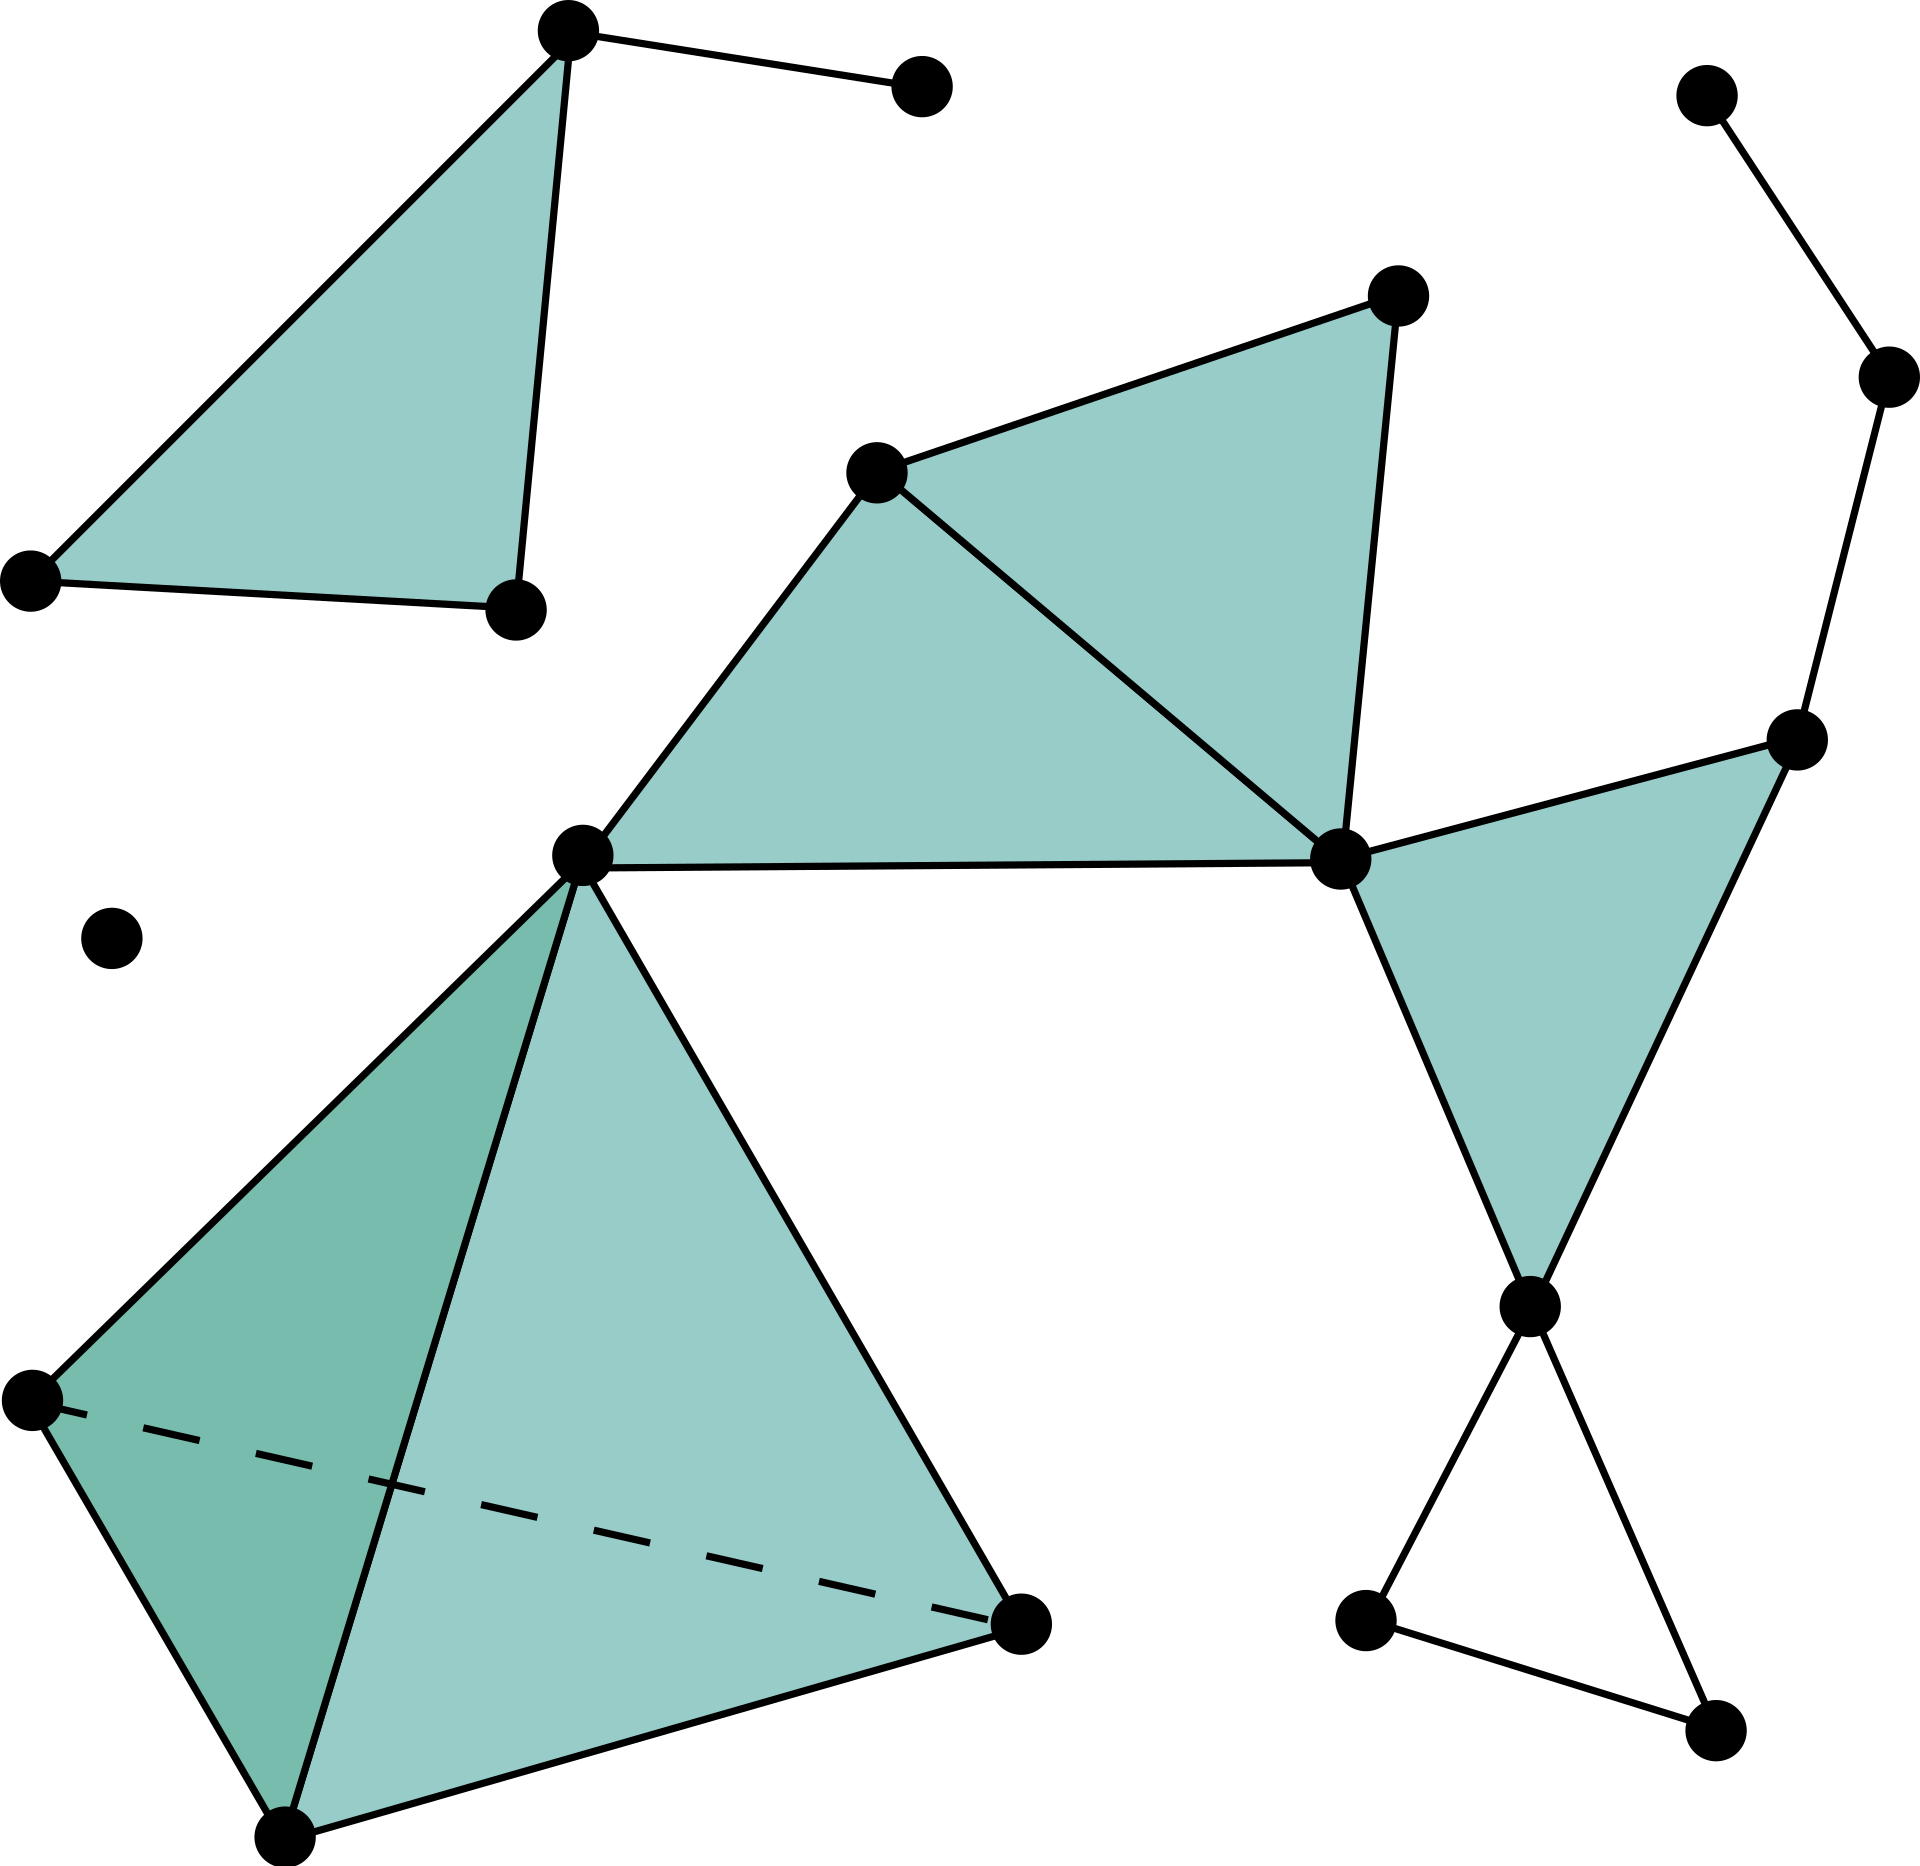
</div>

We therefore want to build a **Vietoris-Rips complex** graph from using the information from the structural connectivity. In topology, Vietoris-Rips complex is an abstract simplicial complex that can be created based on a set of points, and  distance metric $\epsilon$, whereby we form a simplex for every set of points that are within a distance $\epsilon$. 

An example of a Vietoris-Rips complex is shown below [Wiki]


<div>
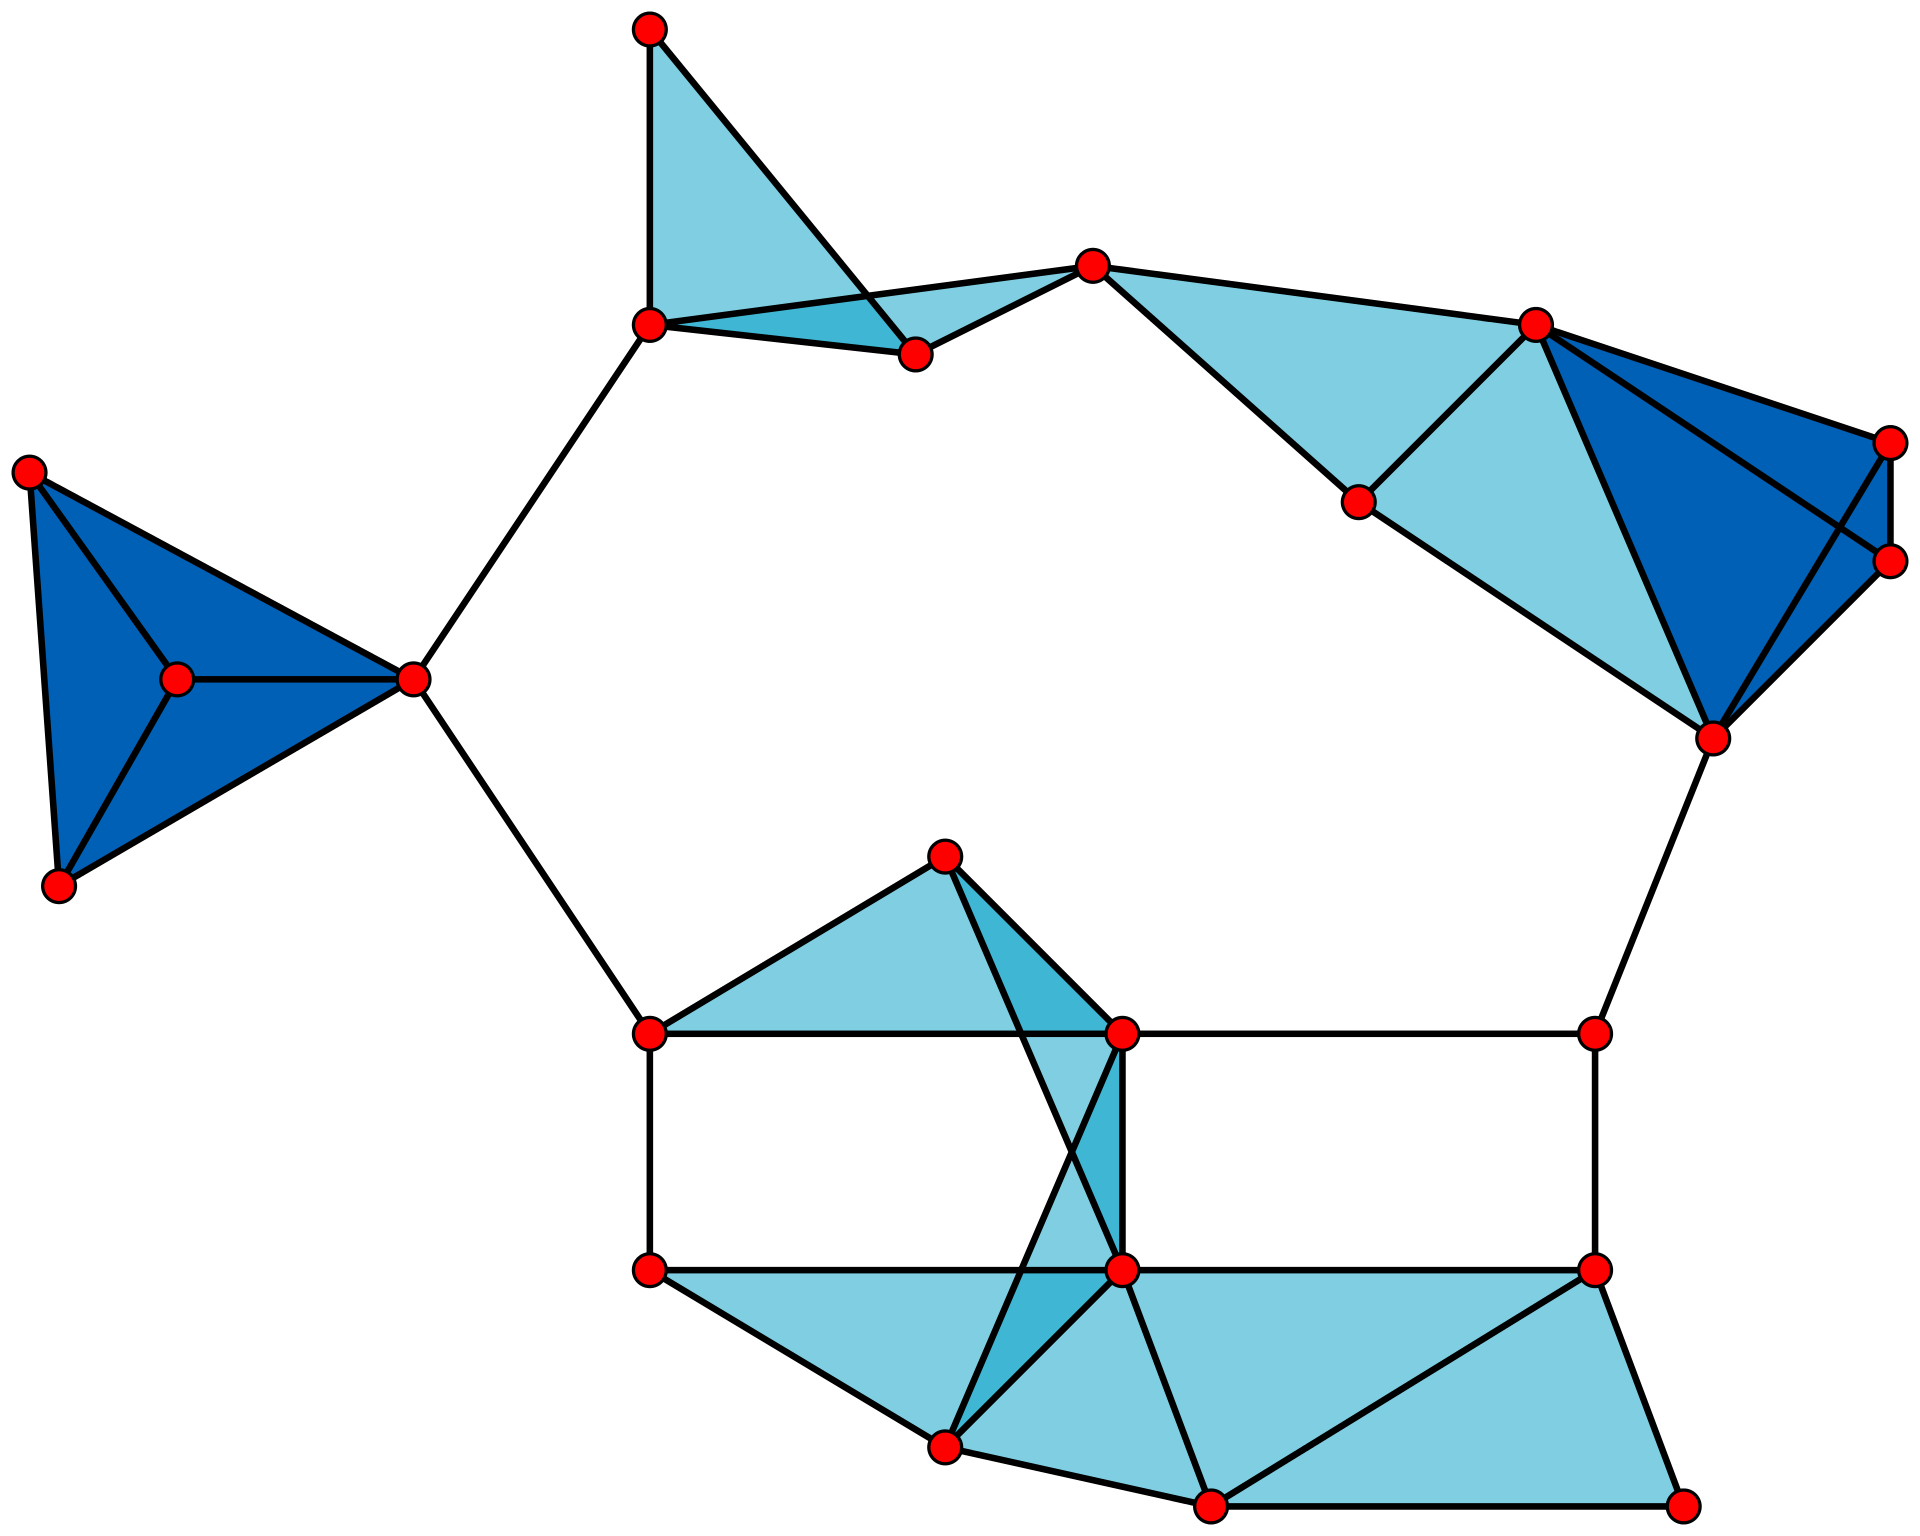
</div>


### Steps to take in building the Vietoris-Rips complex

First we take each region of the brain as our points, and define a distance metric we want. We do this for the averaged SC and for each of the individual SC. 

What are the available weights in the connectivity graph?
    1. Normalized fiber density
    2. Fiber lengths (mean)
    3. Isotropy measures
    
So far, we have been assessing the normalized fiber density. So let's start with that. The distance metric in this case is therefore reflecting the amount of fiber connections between each pair of regions. Should we take the inverse of this? The higher the fiber density, the closer the two points are.

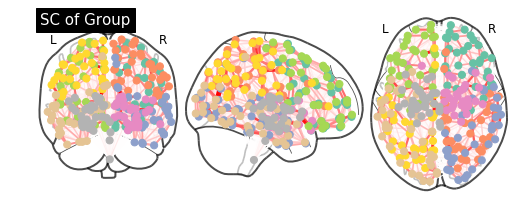

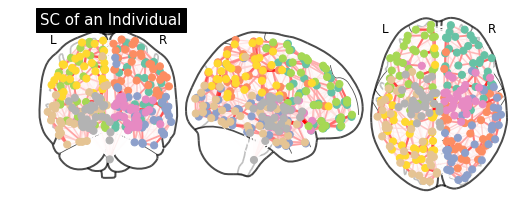

In [19]:
# useful for plotting connectivity on glass brain
from nilearn import plotting
topology_path='/Users/anjalitarun/Documents/CHUV/HCP/Procrustes_Project'
f = sio.loadmat(topology_path + '/Lausanne2018_scale3_MNI_coordinates.mat')
coordinates = f['coord']['offset']
coord = np.array(coordinates)
# plot connectome with 50% edge strength in the connectivity
plotting.plot_connectome(An_group_recon, coord[0][0],
                         edge_threshold="80%",
                         title='SC of Group')
plotting.plot_connectome(An_rotated[:,:,1], coord[0][0],
                         edge_threshold="80%",
                         title='SC of an Individual')
plotting.show()

Here, the first step to do is to build the Vietoris-Rips complex by providing the skeleton of the graph. We use $\epsilon =$ 1e5 as our threshold. This is arbitrary and we can explore this parameter later on.

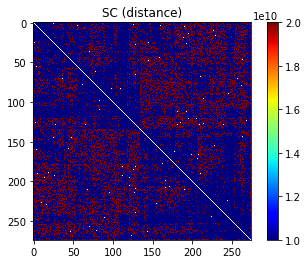

In [108]:

nsubjects = n_subj

# Initialize bottleneck distances between subject-level and group-averaged 
b0_sub = np.zeros((nsubjects))
b1_sub = np.zeros((nsubjects))
b2_sub = np.zeros((nsubjects))

#sc_avg = np.where(An_group_recon, An_group_recon, 1e-5)
# Convert SC to distance matrix
sc_avg_dist = np.power(An_group_recon, -1)
sc_avg_dist2 = (sc_avg_dist + np.transpose(sc_avg_dist))/2
plt.imshow(sc_avg_dist2,cmap='jet',vmin = 2e10,vmax=1e10)
plt.colorbar()
plt.title('SC (distance)')
plt.show()

Let us evaluate how the number of simplicial complex change as a function of the $\epsilon$. Intuitively, this should go up as we increase the the threshold.

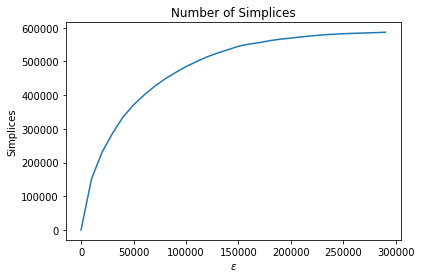

In [105]:
limit = range(0,300000,10000)
number_simplices =np.zeros((len(limit)))
count=0
for epsilon in limit:
    sk = gd.RipsComplex(distance_matrix = abs(sc_avg_dist2), max_edge_length = epsilon)
    rips = sk.create_simplex_tree(max_dimension=2)
    number_simplices[count] = rips.num_simplices()
    count+=1
    
plt.plot(limit, number_simplices)
plt.title('Number of Simplices')
plt.ylabel('Simplices')
plt.xlabel('$\epsilon$')
plt.show()

There is a point to which the number of simplices stabilizes. This is also dictated by the number of vertices in the graph (N=274 brain regions). To start, let's use $\epsilon$ = 1E5

In [97]:
# Build the Vietoris-Rips complex
epsilon=1e3
skeleton_avg = gd.RipsComplex(distance_matrix = abs(sc_avg_dist2), max_edge_length = epsilon)

# Then build the rips simplicial complex
rips_simplex_tree_all = skeleton_avg.create_simplex_tree(max_dimension=2)


Now let's compute the list of simplices in the Rips complex with the get_filtration() function:

In [98]:
rips_filtration = rips_simplex_tree_all.get_filtration()
rips_list = list(rips_filtration)
len(rips_list)

#for splx in rips_list[0:300] :
 #   print(splx)

31350

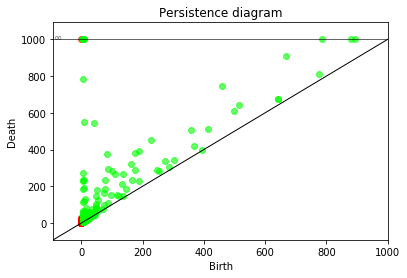

In [99]:
# Now compute persistence on the simplex tree    
barcodes_rips_avg = rips_simplex_tree_all.persistence()
persistence_list0_avg = rips_simplex_tree_all.persistence_intervals_in_dimension(0)
persistence_list1_avg = rips_simplex_tree_all.persistence_intervals_in_dimension(1)
persistence_list2_avg = rips_simplex_tree_all.persistence_intervals_in_dimension(2)
gd.plot_persistence_diagram(barcodes_rips_avg);

/Users/anjalitarun/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:956: RuntimeWarning: overflow encountered in double_scalars
  resdat /= (vmax - vmin)
/Users/anjalitarun/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:955: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/Users/anjalitarun/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:956: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


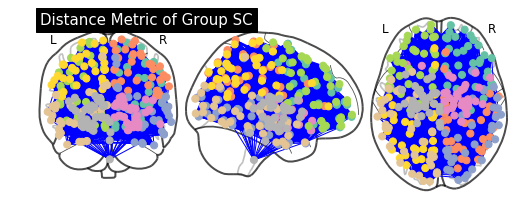

In [91]:
# Plot the distance metric instead of the fiber density
plotting.plot_connectome(abs(sc_avg_dist2), coord[0][0],
                         edge_threshold="85%",
                         title='Distance Metric of Group SC')
plotting.show()

In [95]:
persistence_list1_avg

[(5.393392102916163, 5.696216576568402),
 (6.80891873960403, 7.5216100490541224),
 (6.863466927350883, 7.633000333661723),
 (7.574317609238755, 7.9733470519873455),
 (6.831108607617431, 8.044692450085076),
 (5.155066594390076, 8.375956198751396),
 (7.1830985504039795, 9.171227378510652),
 (7.923135480912238, 9.402388153273922),
 (8.297550766852645, 9.520408195793667),
 (9.804888648604823, 10.356973220882749),
 (8.301863512647069, 10.96997056410713),
 (7.940633666922414, 10.97730239295086),
 (8.983536788772318, 11.263477870820495),
 (11.290503086341399, 11.459534825205788),
 (6.392983216526121, 11.51724254001871),
 (10.05736631923144, 12.071738583957679),
 (10.296445654927146, 12.486538844190884),
 (11.167224228178299, 12.499403473989432),
 (8.825721967893525, 12.658658734092333),
 (8.81199464353912, 12.78144963897197),
 (12.698942867522304, 12.832336623174388),
 (6.453855262501281, 13.38073838992231),
 (13.042541722454533, 13.649556617395632),
 (10.121128054779708, 14.117271909130425),

## Do the same analysis to subject-specific SC

Let's try first with just one subject

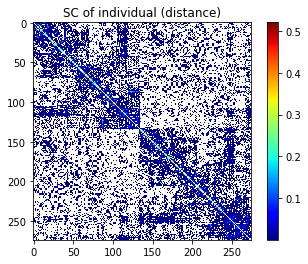

In [88]:
# SC of first subject
sc_sub = np.copy(An_rotated[:,:,iS])
indices = sc_sub<1e-4
sc_sub[indices] = float('inf')
sc_sub_dist = np.power(sc_sub, -1)
#sc_sub_dist2 = (sc_sub_dist + np.transpose(sc_sub_dist))/2
plt.imshow(sc_sub,cmap='jet')
plt.colorbar()
plt.title('SC of individual (distance)')
plt.show()


In [209]:
sc_sub

array([[ 0.00000000e+00,  1.98615553e-01,  2.38184418e-01, ...,
         1.29962582e-04, -5.84750268e-05, -8.26665964e-05],
       [ 1.98615553e-01,  0.00000000e+00,  2.18485705e-01, ...,
         7.76566656e-05, -4.65249781e-05, -1.39727027e-06],
       [ 2.38184418e-01,  2.18485705e-01,  0.00000000e+00, ...,
        -2.79260047e-05,  1.48865145e-04,  9.60839189e-06],
       ...,
       [ 1.29962582e-04,  7.76566656e-05, -2.79260047e-05, ...,
         0.00000000e+00,  8.61909528e-04, -1.35653037e-03],
       [-5.84750268e-05, -4.65249781e-05,  1.48865145e-04, ...,
         8.61909528e-04,  0.00000000e+00,  3.03951482e-04],
       [-8.26665964e-05, -1.39727027e-06,  9.60839189e-06, ...,
        -1.35653037e-03,  3.03951482e-04,  0.00000000e+00]])

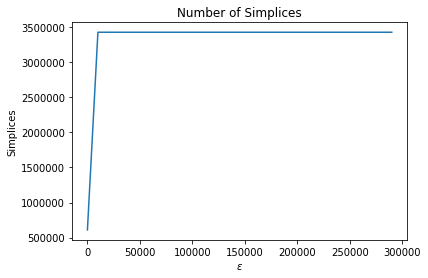

In [89]:

limit = range(0,300000,10000)
number_simplices =np.zeros((len(limit)))
count=0
for epsilon in limit:
    sk = gd.RipsComplex(distance_matrix = abs(sc_sub_dist), max_edge_length = epsilon)
    rips = sk.create_simplex_tree(max_dimension=2)
    number_simplices[count] = rips.num_simplices()
    count+=1
    
plt.plot(limit, number_simplices)
plt.title('Number of Simplices')
plt.ylabel('Simplices')
plt.xlabel('$\epsilon$')
plt.show()

# Build the Vietoris-Rips complex
epsilon=1e3
skeleton_avg = gd.RipsComplex(distance_matrix = abs(sc_sub_dist), max_edge_length = epsilon)

# Then build the rips simplicial complex
rips_simplex_tree_all = skeleton_avg.create_simplex_tree(max_dimension=2)


In [ ]:

# Compute bottleneck distances
for s in range(nsubjects):    
    # Convert SC to distance matrix
    dist_mat_sub = sc_sub_dist[:,:,s]

    # Build the Vietoris-Rips complex        
    # First build the skeleton-graph (MST?)
    skeleton_sub = gd.RipsComplex(distance_matrix = dist_mat_sub, max_edge_length = epsilon)
    
    # Then build the rips simplicial complex        
    rips_simplex_tree_sub = skeleton_sub.create_simplex_tree(max_dimension=3)

    # Now compute persistence on the simplex tree
    barcodes_rips_sub = rips_simplex_tree_sub.persistence()
    persistence_list0_sub = rips_simplex_tree_sub.persistence_intervals_in_dimension(0)
    persistence_list1_sub = rips_simplex_tree_sub.persistence_intervals_in_dimension(1)
    persistence_list2_sub = rips_simplex_tree_sub.persistence_intervals_in_dimension(2)

    b0_sub[s] = gd.bottleneck_distance(persistence_list0_avg,persistence_list0_sub)
    b1_sub[s] = gd.bottleneck_distance(persistence_list1_avg,persistence_list1_sub)
    b2_sub[s] = gd.bottleneck_distance(persistence_list2_avg,persistence_list2_sub)
        
np.save(os.path.join(topology_path,'b0.npy'),b0_sub)
np.save(os.path.join(topology_path,'b1.npy'),b1_sub)
np.save(os.path.join(topology_path,'b2.npy'),b2_sub)


In [ ]:
# Convert SC to distance matrix
s=0
sc_sub_dist = np.power(sc_sub, -1)

# Build the Vietoris-Rips complex        
# First build the skeleton-graph (MST?)
skeleton_sub = gd.RipsComplex(distance_matrix = sc_sub_dist, max_edge_length = epsilon)

# Then build the rips simplicial complex        
rips_simplex_tree_sub = skeleton_sub.create_simplex_tree(max_dimension=3)

# Now compute persistence on the simplex tree
barcodes_rips_sub = rips_simplex_tree_sub.persistence()
persistence_list0_sub = rips_simplex_tree_sub.persistence_intervals_in_dimension(0)
persistence_list1_sub = rips_simplex_tree_sub.persistence_intervals_in_dimension(1)
persistence_list2_sub = rips_simplex_tree_sub.persistence_intervals_in_dimension(2)

b0_sub[s] = gd.bottleneck_distance(persistence_list0_avg,persistence_list0_sub)
b1_sub[s] = gd.bottleneck_distance(persistence_list1_avg,persistence_list1_sub)
b2_sub[s] = gd.bottleneck_distance(persistence_list2_avg,persistence_list2_sub)


# Apply compactness analysis to fMRI graph signals atop the two SC matrices


How does compactness of GFT eigenbasis derived from group-averaged SC measures compare with those derived from individual SC?


In [75]:
def compress(epochs, percentile, axis):
    epochs_p = np.copy(epochs)
    epochs_p[np.linalg.norm(epochs_p, axis=axis) <
             np.percentile(np.linalg.norm(epochs_p, axis=axis),
             percentile), :] = 0
    return epochs_p


def compressErr(epochs, epochs_compressed):
    compression_error = np.linalg.norm(epochs_compressed - epochs) / \
    np.linalg.norm(epochs)
    return compression_error



def compactnessScores(percentiles, ts, sc_avg, sc):
    ntimes, nrois, nsub = ts.shape
    compression_error_indv_GFT = np.zeros((nsub, len(percentiles)))
    correlation_indv_GFT = np.zeros((nsub, len(percentiles)))

    compression_error_avg_GFT = np.zeros((nsub, len(percentiles)))
    correlation_avg_GFT = np.zeros((nsub, len(percentiles)))

    for s in range(nsub):
        # load time-series for subject [ROIs x Time]

        ts_sub = np.nan_to_num(ts[:,:,s])
        sc_avg = np.nan_to_num(sc_avg)
        ts_graph_avg = np.matmul(sc_avg,ts_sub.transpose())

        An_indiv = np.nan_to_num(sc[:,:,s])
        ts_graph_ind = np.matmul(An_indiv,ts_sub.transpose())
        
        for p, percentile in enumerate(percentiles):
        
            # compression error for individual GFT basis
            compressed_ts_GFT = compress(ts_graph_ind,
                                               percentile, 1)
            compression_error_indv_GFT[s, p] = compressErr(ts_graph_ind,
                                                      compressed_ts_GFT)
            correlation_indv_GFT[s, p] = np.corrcoef(ts_graph_ind.flatten(),
                                                compressed_ts_GFT.flatten())[0, 1]
            
            # compression error for avg GFT basis
            compressed_ts_GFT = compress(ts_graph_avg,
                                               percentile, 1)
            compression_error_avg_GFT[s, p] = compressErr(ts_graph_avg,
                                                      compressed_ts_GFT)
            correlation_avg_GFT[s, p] = np.corrcoef(ts_graph_avg.flatten(),
                                                compressed_ts_GFT.flatten())[0, 1]

    return compression_error_indv_GFT, correlation_indv_GFT, compression_error_avg_GFT,
    correlation_avg_GFT


Let's load the fMRI graph signals.... 

In [76]:
topology_path='/Users/anjalitarun/Documents/WORK-CHUV/HCP/Procrustes_Project'
filepath = topology_path + '/50Subjects_RS_NR_Lausanne2018.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)
fMRI = arrays['V_all']
nsubjects = len(subject_list)
ts = np.zeros([4800,274,nsubjects])
for s in range(nsubjects):
    ts_indiv = fMRI[:,(s)*4800:(s+1)*4800].transpose()
    ts[:,:,s]= ts_indiv

<ipython-input-76-21a93c0021e7>:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(filepath)


In [77]:
# Compress the signal and obtain the compression error and the compressibility (correlation)
percentiles = np.arange(0,100,1)

# compression_error_indv_GFT, correlation_indv_GFT, compression_error_avg_GFT, \
#    correlation_avg_GFT = compactnessScores(percentiles, ts, An_group_recon, An_rotated)
from scipy import stats

ntimes, nrois, nsub = ts.shape
compression_error_indv_GFT = np.zeros((nsub, len(percentiles)))
correlation_indv_GFT = np.zeros((nsub, len(percentiles)))

compression_error_avg_GFT = np.zeros((nsub, len(percentiles)))
correlation_avg_GFT = np.zeros((nsub, len(percentiles)))

# roi space
compression_error_indv_ROI = np.zeros((nsub, len(percentiles)))
correlation_indv_ROI = np.zeros((nsub, len(percentiles)))

compression_error_avg_ROI = np.zeros((nsub, len(percentiles)))
correlation_avg_ROI = np.zeros((nsub, len(percentiles)))

sc = An_rotated
sc_avg = An_group_recon
for s in range(nsub):
    # load time-series for subject [ROIs x Time]
    ts_sub = stats.zscore(ts_sub)
    ts_sub = np.nan_to_num(ts[:,:,s])
    sc_avg = np.nan_to_num(sc_avg)
    ts_graph_avg = np.matmul(np.linalg.inv(sc_avg),ts_sub.transpose())

    An_indiv = np.nan_to_num(sc[:,:,s])
    ts_graph_ind = np.matmul(np.linalg.inv(An_indiv),ts_sub.transpose())

    for p, percentile in enumerate(percentiles):
        
        # compression error for individual GFT basis
        compressed_ts_GFT = compress(ts_graph_ind,
                                           percentile, 1)
        
        compressed_ts_indv_ROI = np.matmul(An_indiv,compressed_ts_GFT)
        
        compression_error_indv_GFT[s, p] = compressErr(ts_graph_ind,
                                                  compressed_ts_GFT)
        correlation_indv_GFT[s, p] = np.corrcoef(ts_graph_ind.flatten(),
                                            compressed_ts_GFT.flatten())[0, 1]

        # compression error for avg GFT basis
        compressed_ts_GFT = compress(ts_graph_avg,
                                           percentile, 1)
        
        compressed_ts_avg_ROI = np.matmul(sc_avg,compressed_ts_GFT)
        
        compression_error_avg_GFT[s, p] = compressErr(ts_graph_avg,
                                                  compressed_ts_GFT)
        correlation_avg_GFT[s, p] = np.corrcoef(ts_graph_avg.flatten(),
                                            compressed_ts_GFT.flatten())[0, 1]
        
        #############################
        # Let's also check the compression error in the ROI space
        
        compression_error_indv_ROI[s, p] = compressErr(np.transpose(ts_sub),
                                                  compressed_ts_indv_ROI)
        correlation_indv_ROI[s, p] = np.corrcoef(np.transpose(ts_sub).flatten(),
                                            compressed_ts_indv_ROI.flatten())[0, 1]

        # compression error for avg GFT basis

        compression_error_avg_ROI[s, p] = compressErr(np.transpose(ts_sub),
                                                  compressed_ts_avg_ROI)
        correlation_avg_ROI[s, p] = np.corrcoef(np.transpose(ts_sub).flatten(),
                                            compressed_ts_avg_ROI.flatten())[0, 1]

/Users/anjalitarun/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


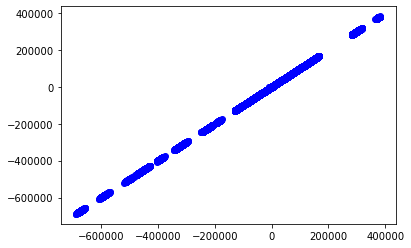

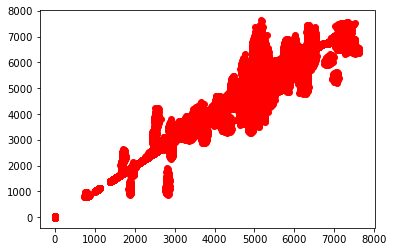

0.981844058212945

In [79]:

sc = An_rotated
sc_avg = An_group_recon
ts_sub = ts[:,:,6]
#ts_sub = stats.zscore(ts_sub)
ts_sub = np.nan_to_num(ts_sub)
xgft = np.linalg.inv(sc_avg)@np.transpose(ts_sub)
percentile = 5
xgft_com = compress(xgft,percentile, 1)
plt.plot(xgft.flatten(), xgft_com.flatten(),'bo')
plt.show()
xroi = sc_avg@xgft
xroi_com = sc_avg@xgft_com
plt.plot(np.transpose(ts_sub).flatten(),xroi_com.flatten(),'ro')
plt.show()

compressErr(xroi,xroi_com)
np.corrcoef(np.transpose(ts_sub).flatten(), xroi_com.flatten())[0, 1]

## Compressibility Metrics

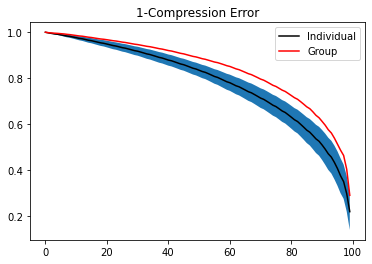

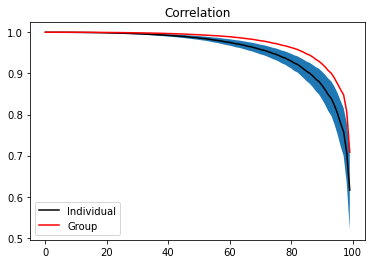

In [80]:
# Plot compression error and compressibility (correlation) on the spectrum space

mean = np.mean(1-compression_error_indv_GFT, axis=0)
standard_dev = np.std(1-compression_error_indv_GFT, axis=0)

plt.plot(percentiles, mean, 'k-')
plt.fill_between(percentiles, mean-standard_dev, mean+standard_dev)
plt.plot(percentiles, 1-compression_error_avg_GFT[0,:],'r-')
plt.title('1-Compression Error')
plt.legend(['Individual', 'Group'])
plt.show()

mean = np.mean(correlation_indv_GFT, axis=0)
standard_dev = np.std(correlation_indv_GFT, axis=0)

plt.plot(percentiles, mean, 'k-')
plt.fill_between(percentiles, mean-standard_dev, mean+standard_dev)
plt.plot(percentiles, correlation_avg_GFT[0,:],'r-')
plt.legend(['Individual', 'Group'])
plt.title('Correlation')
plt.show()

## To do
Plot this together with a randomized connectivity matrix, or a Eucliean distance connectivity matrix.

You can also compare the degree distribution between group averaged SCs and individual SCs. Do this for n-simplex.

Look at the variability of individual SCs to each other.

According to these results, the compressibility of graph signals with respect to the underlying graphs are better in individually generated SCs compared to the group-averaged ones. This is especially true for higher percentiles (80 onwards). Compression errors are also higher in group-averaged SCs compared to individual-level.


## ROI Space

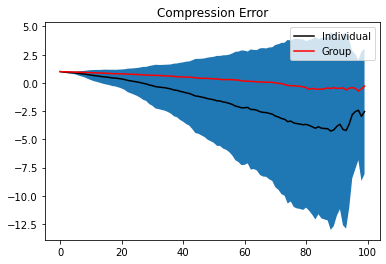

Text(0.5, 1.0, 'Correlation')

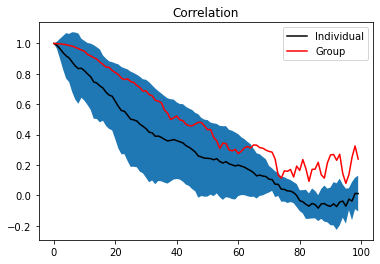

In [81]:
# Plot compression error and compressibility (correlation) on the ROI space

mean = np.mean(1-compression_error_indv_ROI, axis=0)
standard_dev = np.std(1-compression_error_indv_ROI, axis=0)

plt.plot(percentiles, mean, 'k-')
plt.fill_between(percentiles, mean-standard_dev, mean+standard_dev)
plt.plot(percentiles, 1-compression_error_avg_ROI[0,:],'r-')
plt.title('Compression Error')
plt.legend(['Individual', 'Group'])
plt.show()


mean = np.mean(correlation_indv_ROI, axis=0)
standard_dev = np.std(correlation_indv_ROI, axis=0)

plt.plot(percentiles, mean, 'k-')
plt.fill_between(percentiles, mean-standard_dev, mean+standard_dev)
plt.plot(percentiles, correlation_avg_ROI[0,:],'r-')
plt.legend(['Individual', 'Group'])
plt.title('Correlation')

In [82]:
xgft

array([[ -14720.49770693,  -15052.05505357,  -15535.44360214, ...,
          -6198.29377889,   -6088.75546471,   -6144.94570791],
       [  -2380.45702209,   -2481.98876377,   -3082.01976202, ...,
          10600.58977466,   10445.00857636,   10483.81630358],
       [   9744.02318694,    9767.01247532,    9904.43294567, ...,
           6537.79128684,    6647.98371724,    6624.46900394],
       ...,
       [  17826.33750213,   21737.7817598 ,   17369.38416224, ...,
          15924.2491345 ,   16449.21866773,   17158.12386069],
       [-436331.63637596, -440562.53782893, -434205.61141717, ...,
        -467539.86472094, -466574.78425741, -466746.45406846],
       [  86846.47647954,   88213.98008206,   87327.02920754, ...,
         120372.89475885,  118079.92777547,  121221.77540489]])

In [83]:
ts_sub.shape

(4800, 274)